## Imports

In [1]:
from __future__ import division, print_function
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import bilby

%pylab inline
%matplotlib inline

from gwpy.timeseries import TimeSeries
from gwpy.signal import filter_design

Populating the interactive namespace from numpy and matplotlib


### Downoading Open Source gravitational wave data 

In [2]:
interferometers = bilby.gw.detector.networks.InterferometerList(["H1", "L1"])

trigger_time = bilby.gw.utils.get_event_time("150914")
duration = 4
post_trigger_duration = 2
start_time = trigger_time + post_trigger_duration - duration
end_time = start_time + duration
roll_off = 0.2
trigger_time

1126259462.4

Getting analysis data from H1


/home/deepnika/anaconda3/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


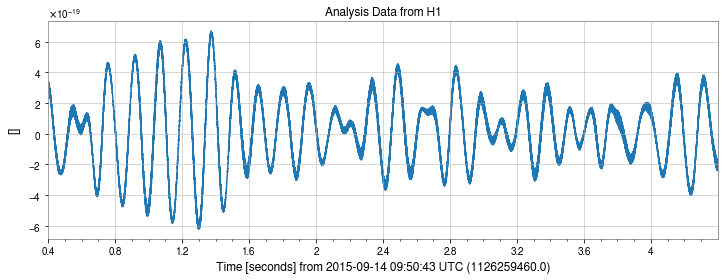

Getting analysis data from L1


/home/deepnika/anaconda3/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


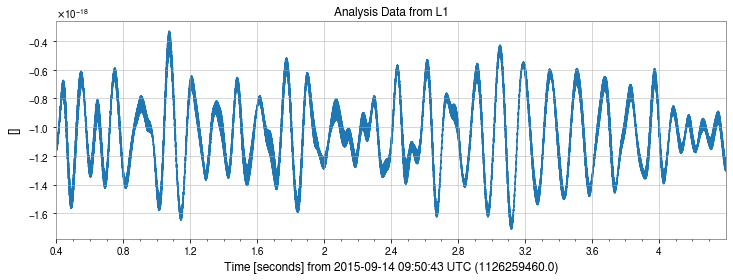

In [3]:
for interferometer in interferometers:
    print("Getting analysis data from {}".format(interferometer.name))
    analysis_data = TimeSeries.fetch_open_data(interferometer.name, start_time, end_time)
    
    analysis_data.plot()
    plt.title("Analysis Data from {}".format(interferometer.name))
    plt.show()
    
    interferometer.strain_data.roll_off = roll_off
    interferometer.strain_data.set_from_gwpy_timeseries(analysis_data)

## Power Spectral Density

In [8]:
psd_duration = duration * 32
psd_start_time = start_time - psd_duration
psd_end_time = psd_start_time + psd_duration
psd_tukey_alpha = 2 * roll_off/duration
overlap = 0

Getting PSD data from H1


/home/deepnika/anaconda3/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


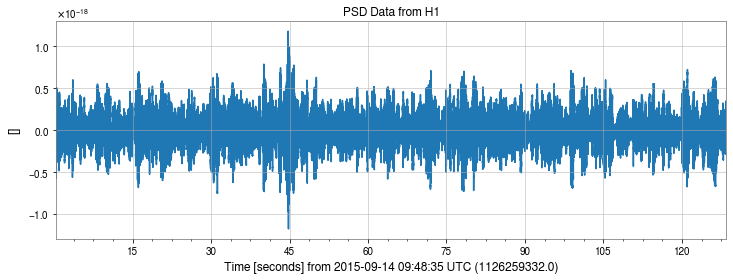

Getting PSD data from L1


/home/deepnika/anaconda3/lib/python3.8/site-packages/gwpy/types/series.py:924: UserWarning: TimeSeries.crop given end larger than current end, crop will end when the Series actually ends.
  warn('%s.crop given end larger than current end, '


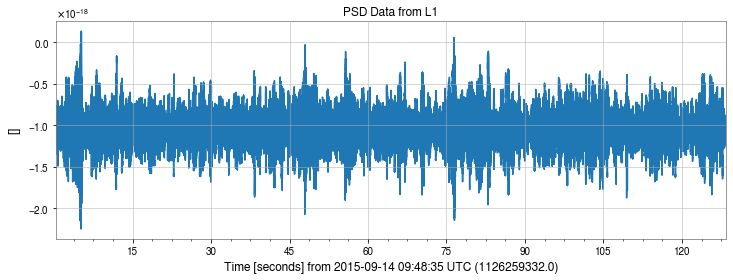

In [9]:
for interferometer in interferometers:
    print("Getting PSD data from {}".format(interferometer.name))
    psd_data = TimeSeries.fetch_open_data(interferometer.name, psd_start_time, psd_end_time, 
                                         sample_rate = 4096, cache = True)
    
    psd_data.plot()
    plt.title("PSD Data from {}".format(interferometer.name))
    plt.show()
    
    psd = psd_data.psd(fftlength = duration, overlap = overlap, 
                       window = ("tukey", psd_tukey_alpha), method ="median")
    
    interferometer.power_spectral_density = bilby.gw.detector.psd.PowerSpectralDensity(
        frequency_array = psd.frequencies.value, psd_array = psd.value)

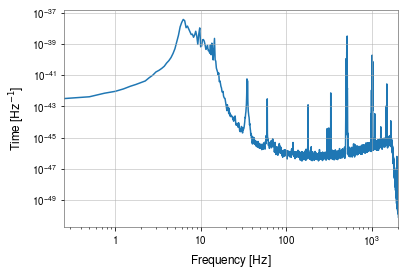

In [10]:
psd.plot()
plt.show()

03:54 bilby INFO    : Generating frequency domain strain from given time domain strain.
03:54 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


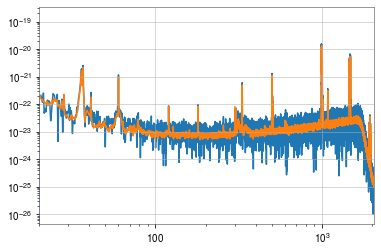

03:54 bilby INFO    : Generating frequency domain strain from given time domain strain.
03:54 bilby INFO    : Applying a tukey window with alpha=0.1, roll off=0.2


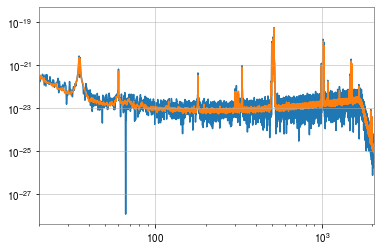

In [11]:
for interferometer in interferometers:
    plt.loglog(interferometer.frequency_array, abs(interferometer.frequency_domain_strain))
    plt.loglog(interferometer.frequency_array, abs(interferometer.amplitude_spectral_density_array))
    plt.xlim(interferometer.minimum_frequency, interferometer.maximum_frequency)
    plt.show()
    plt.close()

In [12]:
prior = bilby.core.prior.PriorDict()
prior['chirp_mass'] = bilby.core.prior.Uniform(name='chirp_mass', minimum=30.0,maximum=32.5)
prior['mass_ratio'] = bilby.core.prior.Uniform(name='mass_ratio', minimum=0.5, maximum=1)
prior['phase'] = bilby.core.prior.Uniform(name="phase", minimum=0, maximum=2*np.pi)
prior['geocent_time'] = bilby.core.prior.Uniform(name="geocent_time", minimum=trigger_time-0.1, 
                                                 maximum=trigger_time+0.1)
prior['a_1'] =  0.0
prior['a_2'] =  0.0
prior['tilt_1'] =  0.0
prior['tilt_2'] =  0.0
prior['phi_12'] =  0.0
prior['phi_jl'] =  0.0
prior['dec'] =  -1.2232
prior['ra'] =  2.19432
prior['theta_jn'] =  1.89694
prior['psi'] =  0.532268
prior['luminosity_distance'] = 412.066

In [13]:
for key in prior:
    print(f"{key}: {prior[key]}")

chirp_mass: Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
mass_ratio: Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
phase: Uniform(minimum=0, maximum=6.283185307179586, name='phase', latex_label='$\\phi$', unit=None, boundary=None)
geocent_time: Uniform(minimum=1126259462.3000002, maximum=1126259462.5, name='geocent_time', latex_label='$t_c$', unit=None, boundary=None)
a_1: 0.0
a_2: 0.0
tilt_1: 0.0
tilt_2: 0.0
phi_12: 0.0
phi_jl: 0.0
dec: -1.2232
ra: 2.19432
theta_jn: 1.89694
psi: 0.532268
luminosity_distance: 412.066


In [14]:
waveform_arguments = dict(
    waveform_approximant="IMRPhenomPv2",
    reference_frequency=100,
    catch_waveform_errors = True)

waveform_generator = bilby.gw.waveform_generator.WaveformGenerator(
                        duration = interferometers.duration,
                        sampling_frequency = interferometers.sampling_frequency,
                        frequency_domain_source_model = bilby.gw.source.lal_binary_black_hole,
                        parameter_conversion = bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters,
                        waveform_arguments = waveform_arguments)

03:56 bilby INFO    : Waveform generator initiated with
  frequency_domain_source_model: bilby.gw.source.lal_binary_black_hole
  time_domain_source_model: None
  parameter_conversion: bilby.gw.conversion.convert_to_lal_binary_black_hole_parameters


In [15]:
likelihood = bilby.gw.likelihood.GravitationalWaveTransient(interferometers = interferometers,
                                                            waveform_generator = waveform_generator, 
                                                            priors = prior, time_marginalization = True,
                                                            distance_marginalization = False,
                                                            phase_marginalization = True)

In [16]:
result = bilby.run_sampler(
    likelihood, prior, sampler='dynesty', outdir='short-GW150914', label="GW150914",
    conversion_function=bilby.gw.conversion.generate_all_bbh_parameters,
    sample="unif", nlive=500, dlogz=3)

03:57 bilby INFO    : Running for label 'GW150914', output will be saved to 'short-GW150914'
03:57 bilby INFO    : Using LAL version Branch: None;Tag: lalsuite-v6.74;Id: b766e8591185f1b59ba22afed547bcf59c6842a7;;Builder: Unknown User <>;Repository status: UNCLEAN: Modified working tree
03:57 bilby INFO    : Search parameters:
03:57 bilby INFO    :   chirp_mass = Uniform(minimum=30.0, maximum=32.5, name='chirp_mass', latex_label='$\\mathcal{M}$', unit=None, boundary=None)
03:57 bilby INFO    :   mass_ratio = Uniform(minimum=0.5, maximum=1, name='mass_ratio', latex_label='$q$', unit=None, boundary=None)
03:57 bilby INFO    :   time_jitter = Uniform(minimum=-0.000244140625, maximum=0.000244140625, name=None, latex_label=None, unit=None, boundary='periodic')
03:57 bilby INFO    :   phase = 0.0
03:57 bilby INFO    :   geocent_time = 1126259460.3999023
03:57 bilby INFO    :   a_1 = 0.0
03:57 bilby INFO    :   a_2 = 0.0
03:57 bilby INFO    :   tilt_1 = 0.0
03:57 bilby INFO    :   tilt_2 = 0.0

0it [00:00, ?it/s]

03:57 bilby INFO    : Using sampler Dynesty with kwargs {'bound': 'multi', 'sample': 'unif', 'verbose': True, 'periodic': None, 'reflective': None, 'check_point_delta_t': 600, 'nlive': 500, 'first_update': None, 'walks': 100, 'npdim': None, 'rstate': None, 'queue_size': 1, 'pool': None, 'use_pool': None, 'live_points': None, 'logl_args': None, 'logl_kwargs': None, 'ptform_args': None, 'ptform_kwargs': None, 'enlarge': 1.5, 'bootstrap': None, 'vol_dec': 0.5, 'vol_check': 8.0, 'facc': 0.2, 'slices': 5, 'update_interval': 300, 'print_func': <bound method Dynesty._print_func of <bilby.core.sampler.dynesty.Dynesty object at 0x7f1f18b14a90>>, 'dlogz': 3, 'maxiter': None, 'maxcall': None, 'logl_max': inf, 'add_live': True, 'print_progress': True, 'save_bounds': False, 'n_effective': None, 'maxmcmc': 5000, 'nact': 5}
03:57 bilby INFO    : Checkpoint every check_point_delta_t = 600s
03:57 bilby INFO    : Using dynesty version 1.0.1
03:57 bilby INFO    : Generating initial points from the prior


912it [00:48, 13.10it/s, bound:0 nc:  4 ncall:3.3e+03 eff:27.9% logz-ratio=266.22+/-0.08 dlogz:3.009>3] 

03:57 bilby INFO    : Written checkpoint file short-GW150914/GW150914_resume.pickle
03:57 bilby INFO    : Writing 202 current samples to short-GW150914/GW150914_samples.dat


913it [00:51, 17.67it/s, bound:0 nc:  1 ncall:3.3e+03 eff:42.8% logz-ratio=268.14+/-0.13 dlogz:0.006>3]

03:58 bilby INFO    : Sampling time: 0:00:40.324623


03:58 bilby INFO    : Reconstructing marginalised parameters.


100%|██████████| 1413/1413 [00:40<00:00, 34.98it/s]

03:58 bilby INFO    : Generating sky frame parameters.



100%|██████████| 1413/1413 [00:00<00:00, 2431.22it/s]


03:58 bilby INFO    : Computing SNRs for every sample.


100%|██████████| 1413/1413 [00:18<00:00, 75.57it/s]


03:59 bilby INFO    : Summary of results:
nsamples: 1413
ln_noise_evidence: -17273.289
ln_evidence: -17005.149 +/-  0.130
ln_bayes_factor: 268.140 +/-  0.130



In [22]:
result.posterior

,chirp_mass,mass_ratio,time_jitter,phase,geocent_time,a_1,a_2,tilt_1,tilt_2,phi_12,...,redshift,comoving_distance,mass_1_source,mass_2_source,chirp_mass_source,total_mass_source,H1_matched_filter_snr,H1_optimal_snr,L1_matched_filter_snr,L1_optimal_snr
0,30.325088,0.677991,-1.226753e-04,4.655246,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,39.050546,26.475933,27.887120,65.526479,19.828597+1.196940j,13.882608,14.309644+0.971025j,9.860630
1,30.479605,0.847749,1.148785e-04,5.380147,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,34.992833,29.665145,28.029214,64.657978,19.794276-1.441910j,14.149087,14.363339-0.887530j,10.069645
2,30.490827,0.739929,-3.863365e-07,1.804217,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,37.528662,27.768543,28.039534,65.297205,19.850359-0.589158j,14.047391,14.334633-0.380499j,9.985573
3,30.481557,0.854305,-2.044333e-04,5.399662,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,34.858384,29.779685,28.031009,64.638069,19.827237+0.202447j,14.153987,14.370793+0.399276j,10.073558
4,30.672505,0.678156,-2.324516e-04,4.609154,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,39.492956,26.782372,28.206606,66.275328,19.985098-0.497742j,14.014820,14.335938-0.209080j,9.948776
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1408,31.523679,0.985187,-7.243396e-05,5.030492,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.549621,33.052643,28.989351,66.602264,19.510944+4.765448j,14.604856,13.844113+3.487510j,10.381194
1409,31.523679,0.985187,-7.243396e-05,5.198142,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.549621,33.052643,28.989351,66.602264,20.033450-1.404002j,14.604856,14.249418-0.868752j,10.381194
1410,31.523679,0.985187,-7.243396e-05,1.939363,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.549621,33.052643,28.989351,66.602264,19.990119+1.889996j,14.604856,14.202401+1.401561j,10.381194
1411,31.523679,0.985187,-7.243396e-05,1.980419,1.126259e+09,0.0,0.0,0.0,0.0,0.0,...,0.087423,378.938183,33.549621,33.052643,28.989351,66.602264,20.011020+1.690426j,14.604856,14.213354+1.332759j,10.381194


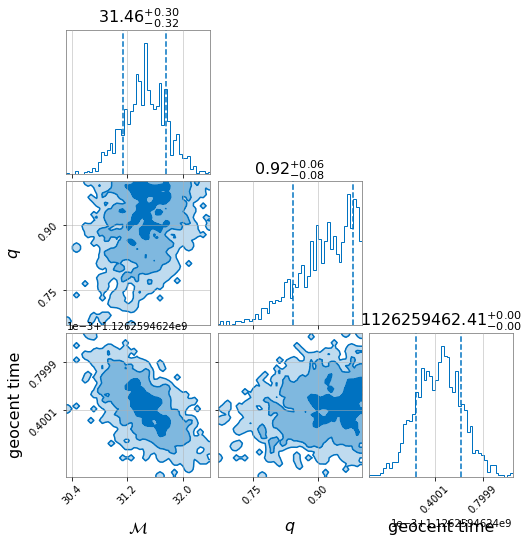

In [25]:
result.plot_corner(parameters=["chirp_mass", "mass_ratio", "geocent_time"], prior=True)